In [2]:
import pandas as pd
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

READING IN AND FORMATTING CBS DATA

In [3]:
# Load the data
from uwv.config import CBS80072NED, CBS_OPENDATA_PROCESSED_DATA_DIR, OUTPUT_DIR

cbs = pd.read_parquet(CBS_OPENDATA_PROCESSED_DATA_DIR / f"{CBS80072NED}.parquet")

2024-09-08 15:18:39.734 | INFO     | uwv.config:<module>:11 - PROJ_ROOT path is: C:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv


In [4]:
# Filter out rows where 'period_quarter_number' is 0
cbs = cbs[cbs['period_quarter_number'] != 0]

# Map quarters to months and create the 'date' column
cbs['month'] = cbs['period_quarter_number'].map({1: 1, 2: 4, 3: 7, 4: 10})
cbs['date'] = pd.to_datetime({'year': cbs['period_year'], 'month': cbs['month'], 'day': 1})

# Set this new 'date' column as the index
cbs.set_index('date', inplace=True)

In [5]:
# Filter data based on 'sbi_title'
sbi_code = 'T001081'  # Example: A-U Alle economische activiteiten
filtered_cbs = cbs[cbs['sbi'] == sbi_code]

# Filter the data to include only dates from 2008 to 2023
filtered_cbs = filtered_cbs.loc['2008-01-01':'2023-12-31']

In [6]:
filtered_cbs.index.freq = 'QS'  # Set the frequency to quarterly

In [7]:
# Check the columns and ensure the sick_leave_percentage column is in the correct format
filtered_cbs['sick_leave_percentage'] = filtered_cbs['sick_leave_percentage'].astype(float)

START PROPHET CODE

In [8]:
# Prepare the data
prophet_data = filtered_cbs.reset_index()[['date', 'sick_leave_percentage']]
prophet_data.columns = ['ds', 'y']  # Renaming columns to match Prophet's expectations

In [9]:
# Initialize and fit the Prophet model
model = Prophet()
model.fit(prophet_data)

15:18:40 - cmdstanpy - INFO - Chain [1] start processing
15:18:40 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# Create a dataframe for future dates
future_dates = model.make_future_dataframe(periods=8, freq='QE')  # 8 quarters into the future

In [11]:
# Make predictions
forecast = model.predict(future_dates)

In [12]:
# View the forecasted values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
67,2024-09-30,5.647169,5.451064,5.865399
68,2024-12-31,6.087252,5.873066,6.306859
69,2025-03-31,5.654310,5.419266,5.873852
70,2025-06-30,5.273393,5.044059,5.475643
71,2025-09-30,5.689775,5.458117,5.917284


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


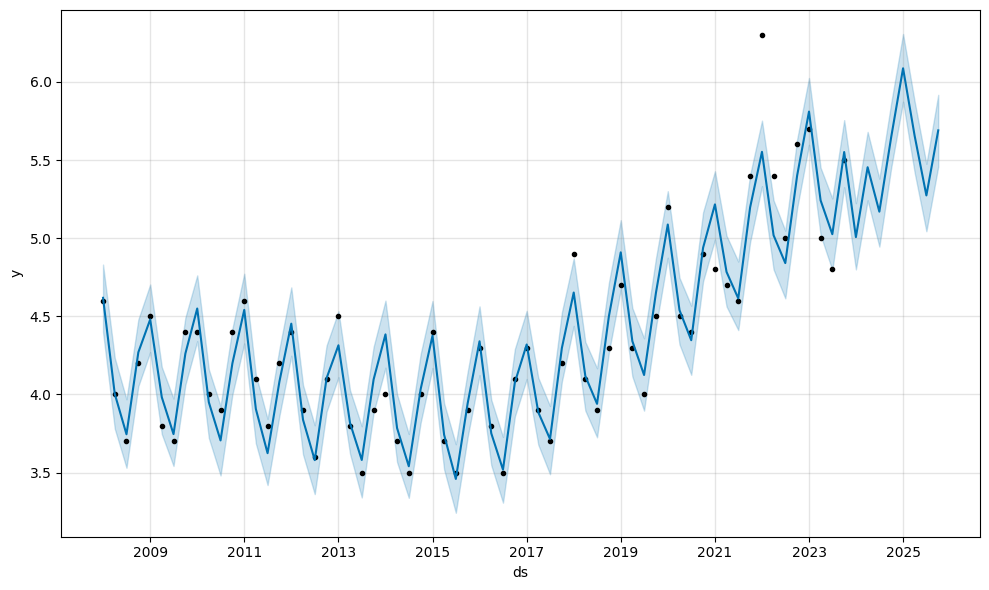

In [13]:
# Plot the forecast
model.plot(forecast)
plt.show()

c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior

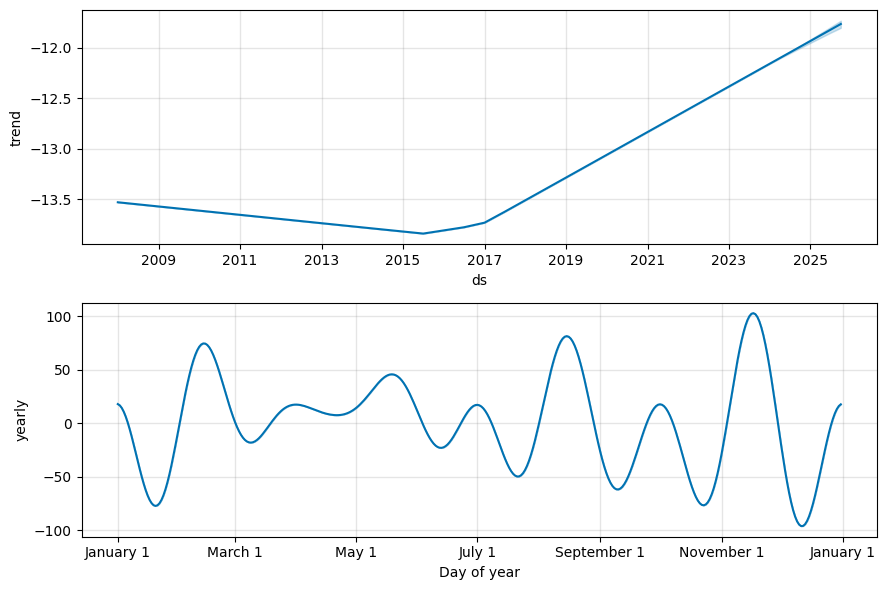

In [14]:
# Plot the forecast components
model.plot_components(forecast)
plt.show()

In [15]:
# Merge the actual and predicted values
comparison_df = prophet_data.merge(forecast[['ds', 'yhat']], on='ds', how='left')

In [16]:
# Drop the rows where yhat is NaN (this will drop future dates where we don't have actual values)
comparison_df.dropna(inplace=True)

In [17]:
# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(comparison_df['y'], comparison_df['yhat'])
mse = mean_squared_error(comparison_df['y'], comparison_df['yhat'])
rmse = np.sqrt(mse)

In [18]:
# Print the evaluation metrics
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 0.114960209890387
MSE: 0.02869102418849359
RMSE: 0.16938425011934727


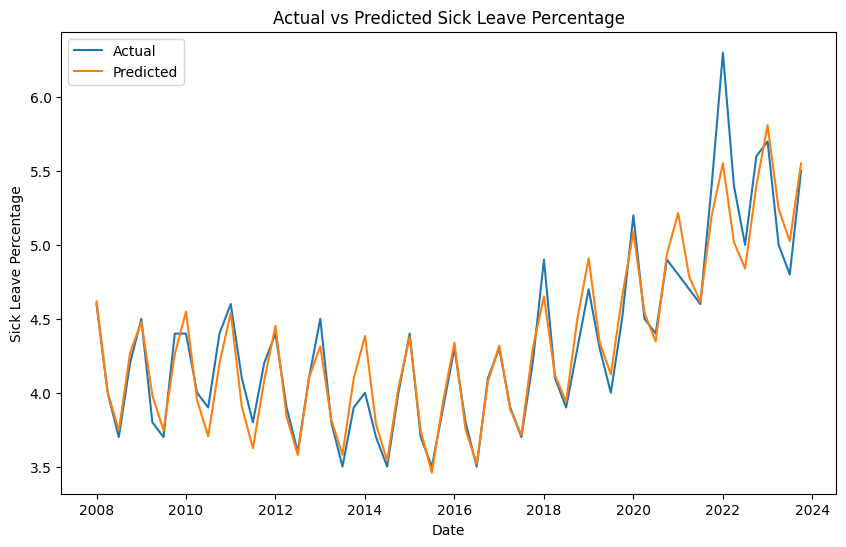

In [19]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['ds'], comparison_df['y'], label='Actual')
plt.plot(comparison_df['ds'], comparison_df['yhat'], label='Predicted')
plt.title('Actual vs Predicted Sick Leave Percentage')
plt.xlabel('Date')
plt.ylabel('Sick Leave Percentage')
plt.legend()
plt.show()

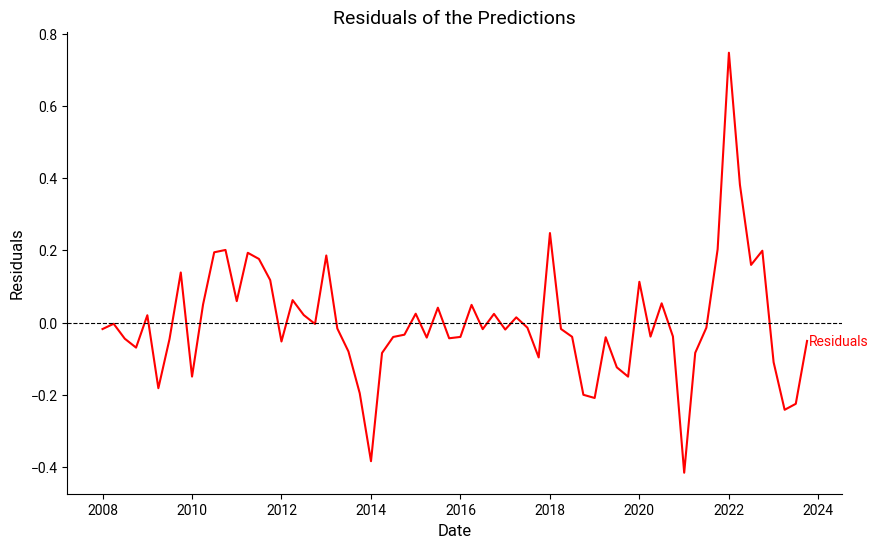

In [25]:

# Add the Roboto font to Matplotlib
font_path = r'C:\Users\c.hakker\AppData\Local\Microsoft\Windows\Fonts\Roboto-Regular.ttf'
fm.fontManager.addfont(font_path)

# Refresh the font cache to include the newly added font
fm._load_fontmanager(try_read_cache=False)

# Set the font family to 'Roboto'
plt.rcParams['font.family'] = 'Roboto'

# Assuming comparison_df is already defined and contains the 'ds', 'y', and 'yhat' columns
comparison_df['residuals'] = comparison_df['y'] - comparison_df['yhat']

plt.figure(figsize=(10, 6))

# Plotting the residuals
plt.plot(comparison_df['ds'], comparison_df['residuals'], label='Residuals', color='red')

# Customizing the plot
plt.title('Residuals of the Predictions', fontsize=14, fontweight='light', fontfamily='Roboto', color='black')
plt.xlabel('Date', fontsize=12, fontfamily='Roboto')
plt.ylabel('Residuals', fontsize=12, fontfamily='Roboto')

# Adding a horizontal line at y=0
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

# Removing the top and right spines (lines)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adding the legend as a label at the end of the line, slightly to the right
plt.text(comparison_df['ds'].iloc[-1] + pd.Timedelta(days=15), comparison_df['residuals'].iloc[-1], 'Residuals', 
         color='red', fontsize=10, va='center')

# Customizing the ticks and font size
plt.xticks(fontsize=10, fontfamily='Roboto')
plt.yticks(fontsize=10, fontfamily='Roboto')

plt.show()


Residuals represent the difference between the actual observed values and the values predicted by the model. Mathematically, a residual is calculated as:

Residual = Actual Value − Predicted Value

Measure of Prediction Error: Residuals indicate how much the model's predictions deviate from the actual observed values. A residual close to zero suggests that the prediction was accurate, while a large residual indicates a significant difference between the predicted and actual values.
